# Machine Learning Models and Evaluation

This notebook evaluates several supervised machine learning  models for predicting health outcomes using a leakage-aware preprocessing pipeline. Multiple classifiers are compared using cross-validation, followed by hyperparameter optimization and analysis of model performance.

The impact of missing data is also examined by comparing results obtained from complete data with those using simple imputation strategies.


## Datasets

Two versions of the same dataset were used in this analysis: one containing missing values and the other without. The version with missing values was derived from the complete dataset:

- [github.com/turcotte/csi4106-f25/tree/main/assignments-data/a2](https://github.com/turcotte/csi4106-f25/tree/main/assignments-data/a2)

You can access and read the data directly from this GitHub repository.

- [alien_pet_health-realism-clean.csv](https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv)
- [alien_pet_health-realism-clean-missing.csv](https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean-missing.csv)

## Approach

**Dataset Loading and Initial Inspection**

The dataset is loaded into a pandas DataFrame and is inspected to understand its dimensionality and a sample of its records.



In [154]:
import pandas as pd

# Display all columns when printing a DataFrame
pd.set_option('display.max_columns', None)

# Github URL of the dataset
url = "https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

# Display shape
print(f"Dataset shape: {df.shape}")
print(f"  Rows: {df.shape[0]}")
print(f"  Columns: {df.shape[1]}")

# Display the first five rows
print("\nFirst 5 rows of the dataset:\n")
df.head()


Dataset shape: (5000, 8)
  Rows: 5000
  Columns: 8

First 5 rows of the dataset:



,thermoreg_reading,enzyme_activity_index,dual_lobe_signal,stress_variability,habitat_zone,activity_score,fasting_flag,health_outcome
0,52.6,97.0,3.6,-3.5,c2,2,0,1
1,41.8,105.0,3.4,10.5,c1,2,0,0
2,56.2,126.0,5.5,9.6,c2,5,0,0
3,57.7,106.0,-4.1,-4.0,c1,4,0,1
4,34.5,73.0,2.3,0.3,c4,5,1,1


**Feature Distribution Analysis**


Feature distributions were examined to inform encoding and scaling decisions. Visual inspection using histograms and box plots supported data-driven preprocessing choices for both numerical and categorical attributes.


Numeric Columns: 



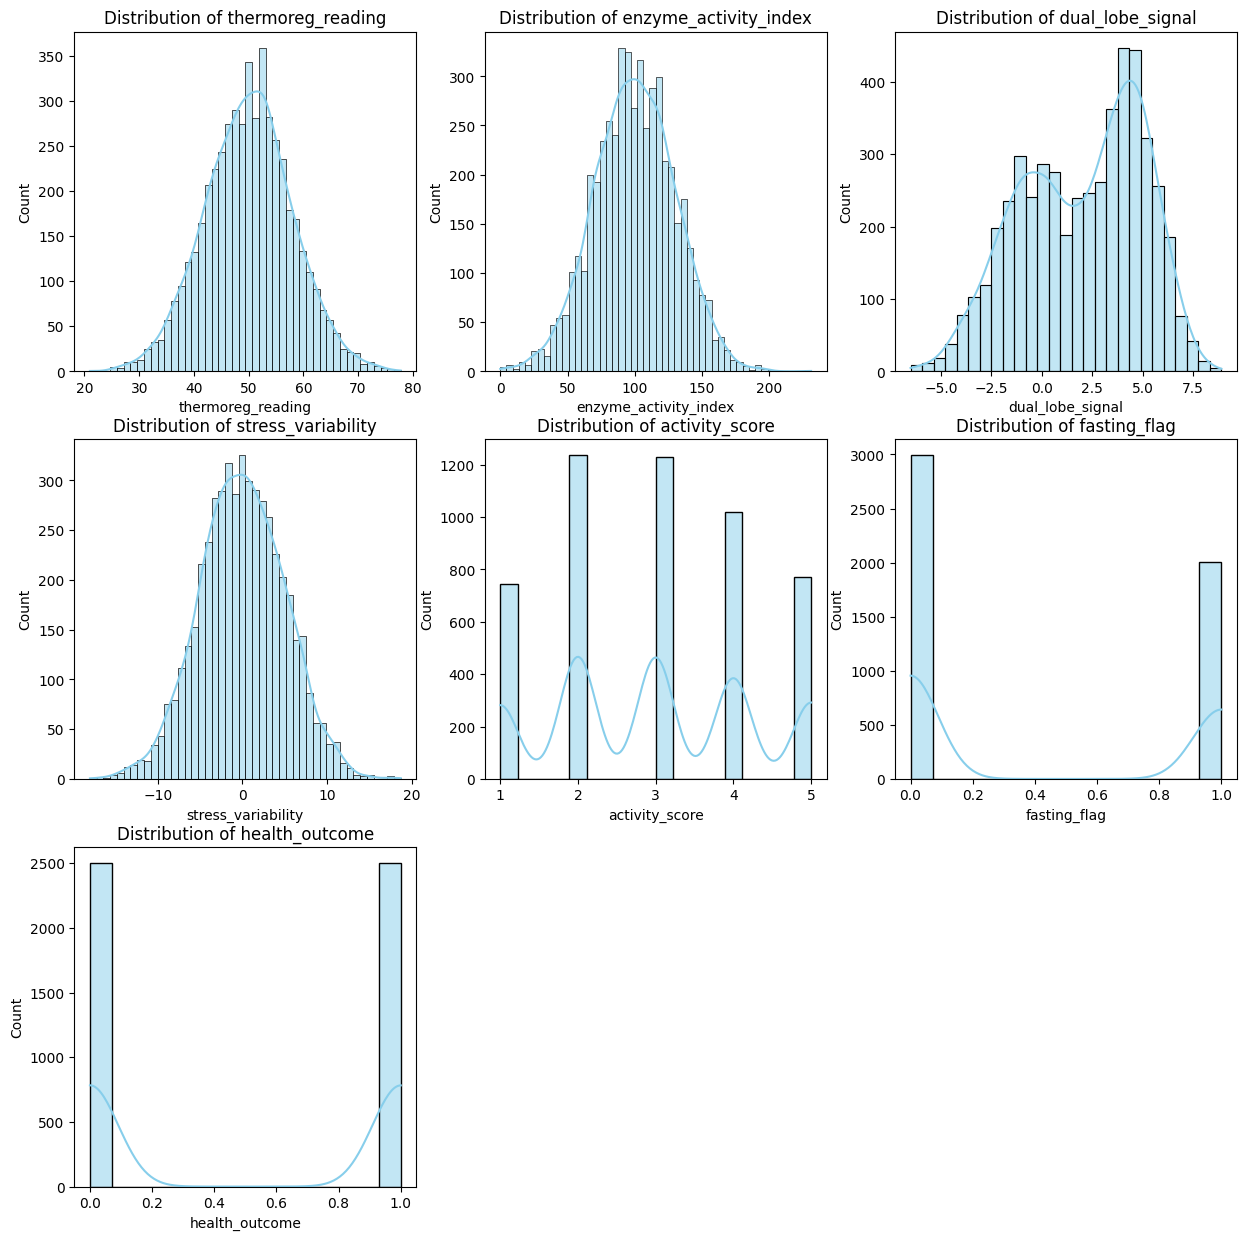

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nNumeric Columns: \n")

# Get numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Histograms

n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Generate Histograms
for idx, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f"Distribution of {col}")

# Hide extra subplots if any
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout
plt.show()


Categorical Columns: 



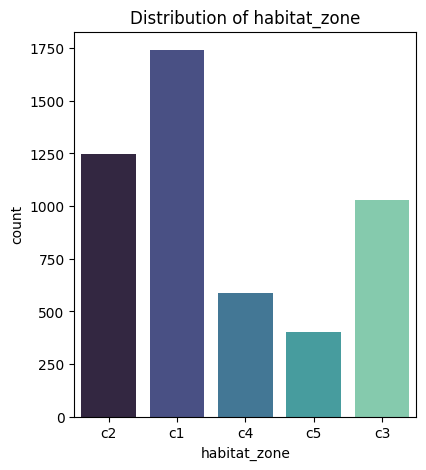

In [156]:
print("\nCategorical Columns: \n")

# Get categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Count plot

n_cols = len(categorical_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Generate Count plots
for idx, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue=col, ax=axes[idx], palette='mako')
    axes[idx].set_title(f"Distribution of {col}")

# Hide extra subplots if any
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout
plt.show()

In [157]:
# Data and target class

X = df.drop(columns=['health_outcome'])
y = df['health_outcome']

**Data Splitting**

The dataset was split into training and test sets using an 80/20 holdout strategy. This split was performed prior to any preprocessing to prevent data leakage.

In [158]:
from sklearn.model_selection import train_test_split

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Pre-Processing

**Categorical Variable Encoding**

Categorical features were encoded using appropriate techniques to produce numerical representations suitable for machine learning models. The encoding strategy was selected based on feature cardinality and distribution.

In [159]:
from sklearn.preprocessing import OneHotEncoder

# Encoding
categorical = ['habitat_zone']

onehot_encoder = OneHotEncoder(sparse_output=False)

categorical_X_train = onehot_encoder.fit_transform(X_train[categorical])
categorical_X_test = onehot_encoder.transform(X_test[categorical])



I applied One-Hot Encoding to the categorical feature because it has no intrinsic order or ranking. One-Hot represents each category as a binary vector containing a single '1', with all other elements being '0'. This prevents the algorithm from assuming any ordinal relationship between categories, and therefore not imposing a false numerical hierarchy.

**Normalization/Standardization of Numerical Features**

Numerical features were scaled to ensure comparable magnitudes across dimensions. Scaling parameters were fit exclusively on the training data and applied unchanged to the test data.

In [160]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scaling
numerical = ['thermoreg_reading', 'enzyme_activity_index', 'dual_lobe_signal', 'stress_variability']

standard_scaler = StandardScaler()

numerical_X_train = standard_scaler.fit_transform(X_train[numerical])
numerical_X_test = standard_scaler.transform(X_test[numerical])

X_train_final = np.concatenate([numerical_X_train, categorical_X_train], axis = 1)
X_test_final = np.concatenate([numerical_X_test, categorical_X_test], axis = 1)


I applied Standard Scaler to the numerical features because it ensures balanced feature contribution and improves model convergence/distance fairness. Standard Scaler standardizes each feature to have a mean of 0 and standard deviation of 1. This is appropriate because the variables roughly exhibit symmetric, bell-shaped distributions, which align with the assumptions of standardization.



### Model Development & Evaluation

**Model Development**

Several classification models were trained using default hyperparameters to
establish baseline performance. The evaluated models included K-Nearest Neighbors, Decision Trees, Logistic Regression, and Random Forests.

In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# KNN

knn = KNeighborsClassifier()
knn.fit(X_train_final, y_train)
y_pred_knn = knn.predict(X_test_final)

# Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X_train_final, y_train)
y_pred_dt = dt.predict(X_test_final)

# Logistic Regression

lr = LogisticRegression()
lr.fit(X_train_final, y_train)
y_pred_lr = lr.predict(X_test_final)

# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train_final, y_train)

y_pred_rf = rf.predict(X_test_final)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


KNN Accuracy: 0.835
Decision Tree Accuracy: 0.777
Logistic Regression Accuracy: 0.701
Random Forest Accuracy: 0.864


**Model Evaluation**

Model performance was evaluated using cross-validation. Precision, recall, and F1-score were used as primary metrics, and performance variability across folds was reported.

In [162]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Cross-validation

models = {'K-Nearest Neighbours': knn, 'Decision Tree': dt, 'Logistic Regression': lr, 'Random Forest': rf}


print("\nCross validation Mean and Standard Deviation:\n")
for name, model in models.items():
    clf_scores = cross_val_score(model, X_train_final, y_train, cv=5) # 5 folds is a standard and efficient choice
    print(f"{name} Mean: {clf_scores.mean():.4f}")
    print(f"{name} Standard deviation: {clf_scores.std():.4f}\n")

# Precision, Recall, F1-score

print("\nPrecision, Recall, F1-score metrics:\n")
for name, model in models.items():
    y_pred = model.predict(X_test_final)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name} Precision: {precision:.4f}")
    print(f"{name} Recall: {recall:.4f}")
    print(f"{name} F1-score: {f1:.4f}\n")






Cross validation Mean and Standard Deviation:

K-Nearest Neighbours Mean: 0.8380
K-Nearest Neighbours Standard deviation: 0.0098

Decision Tree Mean: 0.7943
Decision Tree Standard deviation: 0.0068

Logistic Regression Mean: 0.6747
Logistic Regression Standard deviation: 0.0109

Random Forest Mean: 0.8500
Random Forest Standard deviation: 0.0031


Precision, Recall, F1-score metrics:

K-Nearest Neighbours Precision: 0.8198
K-Nearest Neighbours Recall: 0.8545
K-Nearest Neighbours F1-score: 0.8368

Decision Tree Precision: 0.7776
Decision Tree Recall: 0.7697
Decision Tree F1-score: 0.7736

Logistic Regression Precision: 0.6639
Logistic Regression Recall: 0.8020
Logistic Regression F1-score: 0.7264

Random Forest Precision: 0.8597
Random Forest Recall: 0.8667
Random Forest F1-score: 0.8632



### Hyperparameter Optimization

**Exploration and Performance Evaluation:**

Key hyperparameters for each model were explored using grid search combined with cross-validation. Mean performance and variability were analyzed to identify optimal configurations.

In [163]:
from sklearn.model_selection import GridSearchCV

scoring = {'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# KNN

print("K-Nearest Neighbours\n")

print("Default Params: {'n_neighbors': 5, 'weights': 'uniform'}\n")

knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

knn_grid = GridSearchCV(knn, param_grid=knn_params, scoring=scoring, refit='f1', cv=5)

knn_grid.fit(X_train_final, y_train)

print("KNN Best Params:", knn_grid.best_params_)
print("KNN Best F1:", knn_grid.best_score_)

pd.DataFrame(knn_grid.cv_results_)[[
    'params',
    'mean_test_precision',
    'std_test_precision',
    'mean_test_recall',
    'std_test_recall',
    'mean_test_f1',
    'std_test_f1'
]]


K-Nearest Neighbours

Default Params: {'n_neighbors': 5, 'weights': 'uniform'}

KNN Best Params: {'n_neighbors': 11, 'weights': 'uniform'}
KNN Best F1: 0.8497071870277468


,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.815827,0.012667,0.852802,0.017507,0.833834,0.013081
1,"{'n_neighbors': 3, 'weights': 'distance'}",0.816277,0.013636,0.848309,0.017473,0.831885,0.012663
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.824040,0.010289,0.860776,0.025903,0.841719,0.011627
3,"{'n_neighbors': 5, 'weights': 'distance'}",0.826683,0.009350,0.857778,0.025225,0.841668,0.010910
4,"{'n_neighbors': 7, 'weights': 'uniform'}",0.827346,0.013026,0.866272,0.016703,0.846193,0.009024
5,"{'n_neighbors': 7, 'weights': 'distance'}",0.830844,0.011363,0.861279,0.017731,0.845620,0.008823
6,"{'n_neighbors': 9, 'weights': 'uniform'}",0.829052,0.013531,0.861778,0.013606,0.844921,0.005918
7,"{'n_neighbors': 9, 'weights': 'distance'}",0.831802,0.013145,0.859287,0.015536,0.845144,0.007585
8,"{'n_neighbors': 11, 'weights': 'uniform'}",0.832346,0.010659,0.868271,0.022841,0.849707,0.011053
9,"{'n_neighbors': 11, 'weights': 'distance'}",0.830539,0.012244,0.863778,0.020200,0.846597,0.008704


In [164]:
# Decision Tree

print("Decision Tree\n")

print("Default Params: {'criterion': 'gini', 'max_depth': None}\n")

dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 10, None]}

dt_grid = GridSearchCV(dt, param_grid=dt_params, scoring=scoring, refit='f1', cv=5)

dt_grid.fit(X_train_final, y_train)

print("Decision Tree Best Params:", dt_grid.best_params_)
print("Decision Tree Best F1:", dt_grid.best_score_)

pd.DataFrame(dt_grid.cv_results_)[[
    'params',
    'mean_test_precision',
    'std_test_precision',
    'mean_test_recall',
    'std_test_recall',
    'mean_test_f1',
    'std_test_f1'
]]



Decision Tree

Default Params: {'criterion': 'gini', 'max_depth': None}

Decision Tree Best Params: {'criterion': 'entropy', 'max_depth': 10}
Decision Tree Best F1: 0.8182339619193222


,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
0,"{'criterion': 'gini', 'max_depth': 3}",0.630011,0.011187,0.922152,0.011551,0.748527,0.009645
1,"{'criterion': 'gini', 'max_depth': 5}",0.682219,0.027765,0.869224,0.054469,0.762784,0.016100
2,"{'criterion': 'gini', 'max_depth': 7}",0.739942,0.032664,0.853292,0.029150,0.791746,0.018419
3,"{'criterion': 'gini', 'max_depth': 10}",0.779957,0.014386,0.843324,0.026022,0.810045,0.011140
4,"{'criterion': 'gini', 'max_depth': None}",0.793918,0.010468,0.788928,0.018507,0.791216,0.008680
5,"{'criterion': 'entropy', 'max_depth': 3}",0.629327,0.011603,0.921155,0.012095,0.747719,0.010324
6,"{'criterion': 'entropy', 'max_depth': 5}",0.671054,0.027012,0.883688,0.054701,0.760971,0.009604
7,"{'criterion': 'entropy', 'max_depth': 7}",0.747216,0.023207,0.866258,0.025759,0.801896,0.015076
8,"{'criterion': 'entropy', 'max_depth': 10}",0.775084,0.016453,0.866774,0.013462,0.818234,0.011153
9,"{'criterion': 'entropy', 'max_depth': None}",0.798625,0.008026,0.804893,0.014962,0.801643,0.007812


In [165]:
# Logistic Regression

print("Logistic Regression\n")

print("Default Params: {'penalty': 'l2', 'max_iter': 100, 'tol': 1e-4}\n")

lr_params = {'penalty': ['l2', None], 'max_iter': [100, 500, 1000], 'tol': [1e-4, 1e-3, 1e-2]}

lr_grid = GridSearchCV(lr, param_grid=lr_params, scoring=scoring, refit='f1', cv=5)

lr_grid.fit(X_train_final, y_train)

print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Best F1:", lr_grid.best_score_)

pd.DataFrame(lr_grid.cv_results_)[[
    'params',
    'mean_test_precision',
    'std_test_precision',
    'mean_test_recall',
    'std_test_recall',
    'mean_test_f1',
    'std_test_f1'
]]


Logistic Regression

Default Params: {'penalty': 'l2', 'max_iter': 100, 'tol': 1e-4}

Logistic Regression Best Params: {'max_iter': 100, 'penalty': 'l2', 'tol': 0.01}
Logistic Regression Best F1: 0.7133531307623432


,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
0,"{'max_iter': 100, 'penalty': 'l2', 'tol': 0.0001}",0.653352,0.011933,0.749001,0.036979,0.697305,0.014917
1,"{'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}",0.653136,0.012596,0.747506,0.036211,0.696583,0.015536
2,"{'max_iter': 100, 'penalty': 'l2', 'tol': 0.01}",0.651399,0.009453,0.789419,0.031265,0.713353,0.010842
3,"{'max_iter': 100, 'penalty': None, 'tol': 0.0001}",0.653765,0.011639,0.748502,0.036802,0.697328,0.014685
4,"{'max_iter': 100, 'penalty': None, 'tol': 0.001}",0.652674,0.012852,0.746010,0.036412,0.695670,0.015966
5,"{'max_iter': 100, 'penalty': None, 'tol': 0.01}",0.651399,0.009453,0.789419,0.031265,0.713353,0.010842
6,"{'max_iter': 500, 'penalty': 'l2', 'tol': 0.0001}",0.653352,0.011933,0.749001,0.036979,0.697305,0.014917
7,"{'max_iter': 500, 'penalty': 'l2', 'tol': 0.001}",0.653136,0.012596,0.747506,0.036211,0.696583,0.015536
8,"{'max_iter': 500, 'penalty': 'l2', 'tol': 0.01}",0.651399,0.009453,0.789419,0.031265,0.713353,0.010842
9,"{'max_iter': 500, 'penalty': None, 'tol': 0.0001}",0.653765,0.011639,0.748502,0.036802,0.697328,0.014685


In [166]:
# Random Forest

print("Random Forest\n")

print("Default Params: {'n_estimators': 100, 'max_depth': None}\n")

rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, None]}

rf_grid = GridSearchCV(rf, param_grid=rf_params, scoring=scoring, refit='f1', cv=5)

rf_grid.fit(X_train_final, y_train)

print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Best F1:", rf_grid.best_score_)

pd.DataFrame(rf_grid.cv_results_)[[
    'params',
    'mean_test_precision',
    'std_test_precision',
    'mean_test_recall',
    'std_test_recall',
    'mean_test_f1',
    'std_test_f1'
]]


Random Forest

Default Params: {'n_estimators': 100, 'max_depth': None}

Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Random Forest Best F1: 0.8545154282807396


,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1
0,"{'max_depth': 5, 'n_estimators': 50}",0.723489,0.022529,0.903680,0.020797,0.803248,0.014462
1,"{'max_depth': 5, 'n_estimators': 100}",0.715767,0.007801,0.910667,0.018151,0.801442,0.008790
2,"{'max_depth': 5, 'n_estimators': 200}",0.720783,0.015434,0.907675,0.016383,0.803321,0.010413
3,"{'max_depth': 10, 'n_estimators': 50}",0.819913,0.002038,0.883722,0.012395,0.850579,0.005832
4,"{'max_depth': 10, 'n_estimators': 100}",0.822442,0.011565,0.888218,0.016686,0.853896,0.007343
5,"{'max_depth': 10, 'n_estimators': 200}",0.824076,0.011668,0.886223,0.012718,0.853853,0.002359
6,"{'max_depth': 20, 'n_estimators': 50}",0.844281,0.014138,0.855792,0.012912,0.849868,0.008499
7,"{'max_depth': 20, 'n_estimators': 100}",0.849151,0.009592,0.855789,0.009370,0.852389,0.005582
8,"{'max_depth': 20, 'n_estimators': 200}",0.846543,0.007491,0.860781,0.009870,0.853528,0.003540
9,"{'max_depth': None, 'n_estimators': 50}",0.846185,0.010358,0.852291,0.015694,0.849077,0.006801


### Model-Specific Observations

**K-Nearest Neighbors (KNN)**

Increasing the number of neighbors from 5 to 11 improved performance by reducing sensitivity to noise and stabilizing predictions through greater neighborhood aggregation. Uniform distance weighting performed best, suggesting relatively uniform data density where distance-based weighting provided no additional benefit.

**Decision Tree**

Entropy marginally outperformed Gini at the optimal tree depth. Constraining tree depth to 10 improved generalization by preventing overfitting to noise in the training data. Trees with unlimited depth exhibited lower recall, indicating memorization of training patterns rather than learning generalizable structure.

**Logistic Regression**

Minimal performance differences were observed between L2 regularization and no regularization, suggesting that all input features contributed meaningfully to prediction. The model converged rapidly, with fewer than 100 iterations required. Increasing the tolerance threshold enabled earlier stopping, acting as implicit regularization without degrading generalization.

**Random Forest**

Increasing the number of estimators from 100 to 200 improved stability and reduced variance by averaging across more trees. As with the Decision Tree, a maximum depth of 10 provided the best trade-off between bias and variance.




**Model Comparison**

Models were compared based on cross-validation performance, stability across folds, and sensitivity to hyperparameter tuning. Differences were interpreted in the context of model complexity, bias–variance trade-offs, and generalization behavior.

### Performance Summary

- **Random Forest** achieved the highest cross-validated F1-score (0.8563),
  demonstrating strong generalization and stability.
- **KNN** performed competitively after tuning (F1 = 0.8497), benefiting from
  reduced sensitivity to noise at higher values of k.
- **Decision Tree** achieved moderate performance (F1 = 0.8201), with depth
  constraints improving generalization.
- **Logistic Regression** performed worst (F1 = 0.7134), indicating that the data
  contains nonlinear patterns not well captured by linear models.

**Observed Differences**

Model Complexity Impact:
- Random Forest achieved the best performance by combining multiple decision trees, reducing variance and improving generalization
- Decision Tree performed worse than Random Forest, demonstrating the power of ensemble methods
- Logistic Regression showed the poorest performance, suggesting the data has non-linear patterns that linear models cannot capture effectively

Overfitting:
- Decision Tree with unlimited depth showed lower F1 compared to depth 10, indicating overfitting
- Depth constraint of 10 was optimal  for both Decision Tree and Random Forest, preventing individual trees from memorizing noise
- KNN with higher k (11) reduced sensitivity to outliers and prevented overfitting to local patterns

Data Imbalance:
- The dataset appears reasonably balanced based on similar precision and recall scores across models
- Random Forest achieved excellent balance

Paramater Tuning Impact
- Random Forest: F1 improved from 0.8511 (default) to 0.8563 (optimized)
- Decision Tree: F1 improved dramatically from 0.7790 (default) to 0.8201 (optimized)
- KNN: F1 improved from 0.8417 (default k=5) to 0.8497 (k=11)
- Logistic Regression: Minimal improvement, suggesting linear models are inherently limited for this problem

**Selected Model**

Based on cross-validation results and overall performance analysis, the Random Forest classifier was selected as the most effective model for this task. It achieved the highest F1-score, demonstrated strong generalization, and maintained balanced precision and recall across classes.

The ensemble structure reduced sensitivity to noise and stabilized predictions, while still providing interpretability through feature importance analysis.

In [167]:
# Random Forest with optimal parameters

optimal_rf = RandomForestClassifier(n_estimators=200, max_depth=10)

optimal_rf.fit(X_train_final, y_train)

y_pred_test = optimal_rf.predict(X_test_final)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Random Forest test set evaluation: \n")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}\n")
print(classification_report(y_test, y_pred_test))

Random Forest test set evaluation: 

Precision: 0.8223
Recall: 0.9071
F1-score: 0.8626

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       505
           1       0.82      0.91      0.86       495

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



### Final Evaluation

Test-set performance closely matched cross-validation results, with an F1-score of 0.863 differing by less than 1% from the validation mean. This consistency indicates that the model did not overfit and that cross-validation provided areliable estimate of real-world performance.

Both classes achieved near-equal F1-scores, confirming that the model performsconsistently across outcomes. Slightly higher recall than precision indicates apreference for correctly identifying positive cases, with minimal impact on overall balance.


### Handling Missing Data

**Impact of Missing Data**

The effect of missing values on model performance was evaluated by comparing results obtained from complete data with those obtained after applying a simple imputation strategy.

In [ ]:
# Read CSV with missing data

missing_url = 'https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a2/alien_pet_health-realism-clean-missing.csv'

df_missing = pd.read_csv(missing_url)

print(f"Dataset shape: {df.shape}")
display(df_missing.head())

# Missing value count and percentage per column
missing_counts = df_missing.isnull().sum()
missing_percent = (missing_counts / len(df_missing)) * 100

# Combine into a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

# Calculate dataset-level totals
total_missing = missing_counts.sum()
overall_missing_pct = (total_missing / (df_missing.shape[0] * df_missing.shape[1])) * 100

# Display results
print(f"Dataset shape: {df_missing.shape}")
print(f"\nTotal Missing Values: {total_missing}")
print(f"Overall Dataset Missing %: {overall_missing_pct:.2f}%\n")

display(missing_summary)


# Breakdown of rows by number of missing values

# Count how many columns are missing per row
missing_per_row = df_missing.isnull().sum(axis=1)

# Count how many rows fall into each missing-value category
row_breakdown = missing_per_row.value_counts().sort_index()

# Calculate percentage of rows for each category
row_percent = (row_breakdown / len(df_missing)) * 100

# Combine into a summary DataFrame
row_summary = pd.DataFrame({'Missing Columns per Row': row_breakdown.index, 'Row Count': row_breakdown.values, 'Row %': row_percent.round(2)
})

# Display total for clarity
print(f"Total rows: {len(df_missing)}\n")
display(row_summary)




Dataset shape: (5000, 8)


,thermoreg_reading,enzyme_activity_index,dual_lobe_signal,stress_variability,habitat_zone,activity_score,fasting_flag,health_outcome
0,52.6,97.0,3.6,-3.5,c2,2.0,0.0,1
1,41.8,105.0,3.4,10.5,c1,2.0,0.0,0
2,56.2,126.0,5.5,9.6,c2,5.0,0.0,0
3,57.7,106.0,-4.1,-4.0,c1,4.0,0.0,1
4,34.5,73.0,2.3,0.3,c4,5.0,1.0,1


Dataset shape: (5000, 8)

Total Missing Values: 1324
Overall Dataset Missing %: 3.31%



,Missing Count,Missing %
fasting_flag,595,11.90
thermoreg_reading,231,4.62
dual_lobe_signal,110,2.20
enzyme_activity_index,108,2.16
activity_score,100,2.00
stress_variability,93,1.86
habitat_zone,87,1.74
health_outcome,0,0.00


Total rows: 5000



,Missing Columns per Row,Row Count,Row %
0,0,3794,75.88
1,1,1095,21.90
2,2,104,2.08
3,3,7,0.14


In [185]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Imputation strategy

# Separate features and target
X = df_missing.drop(columns=['health_outcome'])
y = df_missing['health_outcome']

# Select column types
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(exclude=['number']).columns

# Imputation
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Standardization and encoding
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_cols), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

# Model (using best parameters found earlier)
rf_best = RandomForestClassifier(n_estimators=200, max_depth=10)

# Cross validation (5 folds)
cv_f1 = cross_val_score(rf_best, X_processed, y, cv=5, scoring='f1')
cv_precision = cross_val_score(rf_best, X_processed, y, cv=5, scoring='precision')
cv_recall = cross_val_score(rf_best, X_processed, y, cv=5, scoring='recall')

# Results
print(f"Mean F1 after Imputation: {cv_f1.mean():.4f}, Standard deviation: {cv_f1.std():.4f}")
print(f"Mean Precision: {cv_precision.mean():.4f}, Standard deviation: {cv_precision.std():.4f}")
print(f"Mean Recall: {cv_recall.mean():.4f}, Standard deviation: {cv_recall.std():.4f}")


Mean F1 after Imputation: 0.8377, Standard deviation: 0.0125
Mean Precision: 0.8099, Standard deviation: 0.0109
Mean Recall: 0.8660, Standard deviation: 0.0180


### Imputation Results

After imputation, the model achieved an average F1-score of 0.8377, with precision of 0.8099 and recall of 0.8660. While performance decreased slightly relative to the complete dataset, the drop was modest and expected due to reduced featurevariability and minor noise introduced by imputation.

Overall performance remained stable, indicating that median and most-frequent imputation effectively preserved predictive signal despite the presence of missing data.